In [0]:
!pip install geopandas
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample

import folium
import folium.plugins as plugins
from folium.plugins import HeatMap


In [0]:
# Mounting the Drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Read in airbnb data
airbnb = pd.read_csv('drive/My Drive/AB_NYC_2019.csv')

# Read in NYC location data
nyc = pd.read_csv('drive/My Drive/nynta.csv')

# Read in subway location data
subways = pd.read_csv('drive/My Drive/NYC_Transit_Subway_Entrance_And_Exit_Data.csv')

# Read in Zillow home price data
homes = pd.read_csv('drive/My Drive/Neighborhood_Zhvi_AllHomes.csv')
# Only take the New York City data
homes = homes[homes['City'] == 'New York']

In [0]:
# Average the 2019 home values
homes['2019 value'] = (homes['2019-01']+homes['2019-02']+homes['2019-03']+homes['2019-04']+homes['2019-05']+homes['2019-06']+homes['2019-07']+homes['2019-08']+homes['2019-09'])/9
# Group the home values by region name and save the mean of the region
homes_groupby = homes.groupby('RegionName')[['2019 value']].mean().sort_values(by = '2019 value')

In [0]:
# Merge the airbnb and home data
merged = airbnb.merge(homes_groupby, how = 'left', left_on = 'neighbourhood', right_on = 'RegionName')
merged_na = merged[merged['2019 value'].isna()]
merged_notna = merged[merged['2019 value'].notna()]

In [0]:
# Refer to other code
merged['2019 value_2'] = merged.index.values
def nearest_n(i):
    n = 5
    if merged['2019 value'].isna().iloc[i] == True:
        lat, long = merged_na['latitude'].loc[i], merged_na['longitude'].loc[i]
        temp = merged_notna.copy()
        temp['distance'] = ((temp['latitude'] - float(lat))**2 + (temp['longitude'] - float(long))**2)**.5
        min_series = temp['distance'].sort_values()[:n]
        values = []
        for j in min_series.index.values:
            values.append(merged_notna['2019 value'].loc[j])
        return sum(values)/len(values)
    else:
        return merged['2019 value'].iloc[i]
merged['2019 value_2'] = merged['2019 value_2'].apply(nearest_n)

In [0]:
airbnb = merged.drop(['2019 value'], axis=1)

In [0]:
#Then, since this is a csv file, convert the geometry column text into well known text, this will allow you to plot its geometry correctly
nyc['geom']=nyc['the_geom'].apply(wkt.loads)

#Now convert the pandas dataframe into a Geopandas GeoDataFrame
nyc = gpd.GeoDataFrame(nyc, geometry='geom')

# Change one subway value that is incorrectly positive
subways.at[261, 'Entrance Longitude'] = subways.iloc[261]['Entrance Longitude'] * -1

# creating a geometry column 
geometry = [Point(xy) for xy in zip(subways['Entrance Longitude'], subways['Entrance Latitude'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
subways_geo = gpd.GeoDataFrame(subways, crs=crs, geometry=geometry)

# creating a geometry column for AirBnB data
geometry = [Point(xy) for xy in zip(airbnb['longitude'], airbnb['latitude'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
df_geo = gpd.GeoDataFrame(airbnb, crs=crs, geometry=geometry)

import math

# Function that calculates distance
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

df_geo['index'] = df_geo['id'].index # Make a new column to use as an index

# Put subway locations in a list
a = subways_geo['Entrance Latitude'].values.tolist()
b = subways_geo['Entrance Longitude'].values.tolist()
subway_locations = []
for index, latitude in enumerate(a): 
    temp = [b[index], latitude]
    subway_locations.append(temp)


# Function to Calculate distance to closest Subway Station, Find the Closest Station, and calculate the distance
def closest_subway(index):
    city_coord = df_geo['longitude'].iloc[index], df_geo['latitude'].iloc[index]
    min_distance = 1000000
    
    for subway_loc in subway_locations:
        distance = haversine(city_coord, subway_loc)    
        if (distance < min_distance):
            min_distance = distance
    
    return min_distance

In [0]:
df_geo['Closest Subway'] =  df_geo['index'].map(closest_subway) # Save closest Subway into new column

In [0]:
# Find percent of missing data
total = df_geo.isnull().sum().sort_values(ascending = False)
percent = ((df_geo.isnull().sum())*100)/df_geo.isnull().count().sort_values(ascending=False)
percent
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data

,Total,Percent
reviews_per_month,10052,20.558339
last_review,10052,20.558339
host_name,21,0.042949
name,16,0.032723
index,0,0.000000
geometry,0,0.000000
2019 value_2,0,0.000000
availability_365,0,0.000000
calculated_host_listings_count,0,0.000000
number_of_reviews,0,0.000000


In [0]:
# For missing reviews per month fill in the values with 0's
df_geo['reviews_per_month'] = df_geo['reviews_per_month'].fillna(0)
df_geo.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,2019 value_2,geometry,index,Closest Subway
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,10/19/2018,0.21,6,365,1.018244e+06,POINT (-73.97237 40.64749),0,380.445374
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,5/21/2019,0.38,2,355,1.270278e+06,POINT (-73.98377 40.75362),1,33.337488
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365,8.011444e+05,POINT (-73.94190 40.80902),2,176.884728
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,7/5/2019,4.64,1,194,9.657889e+05,POINT (-73.95976 40.68514),3,112.578298
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,11/19/2018,0.10,1,0,8.011444e+05,POINT (-73.94399 40.79851),4,117.007635


In [0]:
# Drop rows where price = 0
mask=df_geo['price']==0
df_geo = df_geo.drop(df_geo[mask].index)

In [0]:
# convert last_review to datetime
df_geo['last_review'] = pd.to_datetime(df_geo['last_review'],infer_datetime_format=True) 

# fill missing last_review with the earliest date found in data
earliest = min(df_geo['last_review'])
df_geo['last_review'] = df_geo['last_review'].fillna(earliest)


In [0]:
# drop the variables we aren't using for prediction
df_geo_2 = df_geo.drop(['id','name','index','host_id','host_name','geometry'], axis=1)

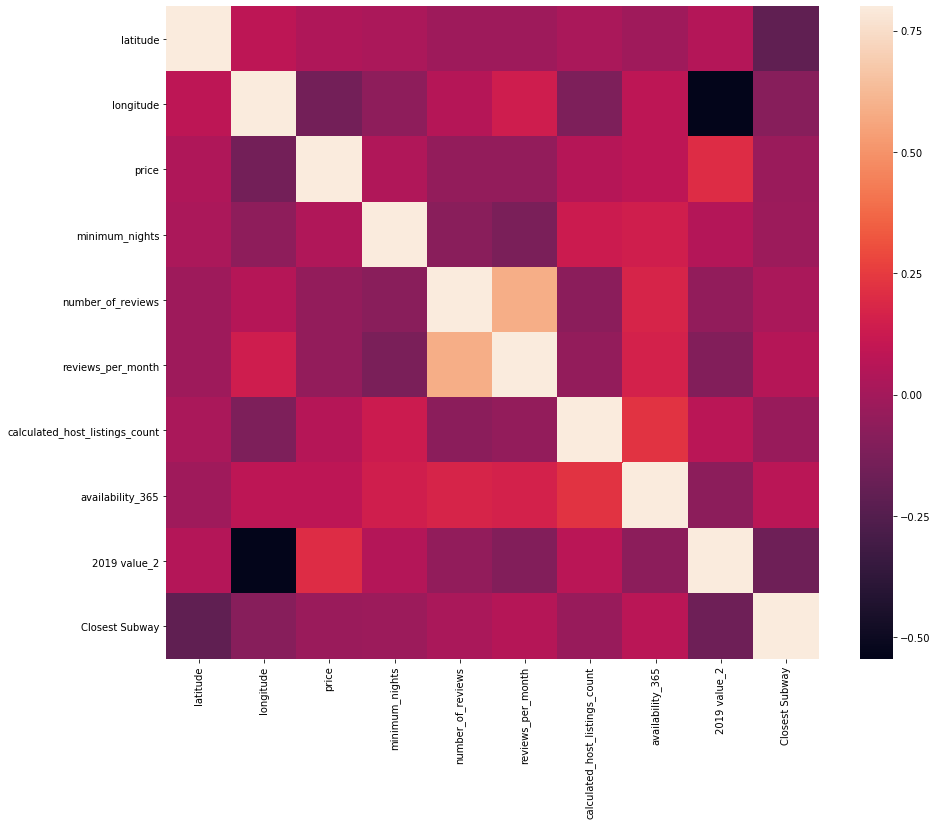

In [0]:
# look at the correlation of the variables
corrmatrix = df_geo_2.corr()
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(corrmatrix, vmax=0.8, square=True)
sns.set(font_scale=0.8)

In [0]:
# Take the log of price and save it as log price
df_geo_2['log_price'] = np.log1p(df_geo_2['price'])

In [0]:
# drop all data where price < 2000
mask = df_geo_2['log_price']<np.log1p(2000)
df_geo_2 = df_geo_2[mask]

In [0]:
# Seperate catgeorical and numerical features
categorical_features = df_geo_2.select_dtypes(include=['object'])
# Turn categorical into dummy variables
categorical_features_one_hot = pd.get_dummies(categorical_features)

numerical_features =  df_geo_2.select_dtypes(exclude=['object'])
y = numerical_features.log_price
# drop log price and price
numerical_features = numerical_features.drop(['price', 'log_price'], axis=1)

X_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)

In [0]:
# save the preprocessed data to a csv
X_df.to_csv('Preprocessed_data.csv')
!cp Preprocessed_data.csv drive/My\ Drive/

In [0]:
X_df.head()

,latitude,longitude,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,2019 value_2,Closest Subway,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,neighbourhood_Astoria,neighbourhood_Bath Beach,neighbourhood_Battery Park City,neighbourhood_Bay Ridge,neighbourhood_Bay Terrace,"neighbourhood_Bay Terrace, Staten Island",neighbourhood_Baychester,neighbourhood_Bayside,neighbourhood_Bayswater,neighbourhood_Bedford-Stuyvesant,neighbourhood_Belle Harbor,neighbourhood_Bellerose,neighbourhood_Belmont,neighbourhood_Bensonhurst,neighbourhood_Bergen Beach,neighbourhood_Boerum Hill,neighbourhood_Borough Park,neighbourhood_Breezy Point,neighbourhood_Briarwood,neighbourhood_Brighton Beach,neighbourhood_Bronxdale,...,neighbourhood_Spuyten Duyvil,neighbourhood_St. Albans,neighbourhood_St. George,neighbourhood_Stapleton,neighbourhood_Stuyvesant Town,neighbourhood_Sunnyside,neighbourhood_Sunset Park,neighbourhood_Theater District,neighbourhood_Throgs Neck,neighbourhood_Todt Hill,neighbourhood_Tompkinsville,neighbourhood_Tottenville,neighbourhood_Tremont,neighbourhood_Tribeca,neighbourhood_Two Bridges,neighbourhood_Unionport,neighbourhood_University Heights,neighbourhood_Upper East Side,neighbourhood_Upper West Side,neighbourhood_Van Nest,neighbourhood_Vinegar Hill,neighbourhood_Wakefield,neighbourhood_Washington Heights,neighbourhood_West Brighton,neighbourhood_West Farms,neighbourhood_West Village,neighbourhood_Westchester Square,neighbourhood_Westerleigh,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,1,9,2018-10-19,0.21,6,365,1.018244e+06,380.445374,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,40.75362,-73.98377,1,45,2019-05-21,0.38,2,355,1.270278e+06,33.337488,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,40.80902,-73.94190,3,0,2011-03-28,0.00,1,365,8.011444e+05,176.884728,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,40.68514,-73.95976,1,270,2019-07-05,4.64,1,194,9.657889e+05,112.578298,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,40.79851,-73.94399,10,9,2018-11-19,0.10,1,0,8.011444e+05,117.007635,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
